In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import scipy.sparse

from xgboost import XGBRegressor

import mlflow
import mlflow.sklearn
from urllib.parse import urlparse

In [ ]:
# experiment_id = mlflow.create_experiment("xgboost_projet_appli_ia")

In [36]:
df_train_modify = pd.read_csv('../../csv/train_modifie.csv')
df_test_modify = pd.read_csv('../../csv/test_modifie.csv')

df_train = df_train_modify.drop(['day_length', 'day_light'], axis=1)
df_test = df_test_modify.drop(['day_length', 'day_light'], axis=1)

In [37]:
X_train = df_train.drop(['registered', 'casual'], axis=1)
y_train_registered = df_train['registered']
y_train_casual = df_train['casual']

X_test = df_test.drop(['registered', 'casual'], axis=1)
y_test_registered = df_test['registered']
y_test_casual = df_test['casual']

In [38]:
X_train_registered, _, y_train_registered, _ = train_test_split(X_train, y_train_registered, test_size=0.00001)
X_train_casual, _, y_train_casual, _ = train_test_split(X_train, y_train_casual, test_size=0.00001)

# Preprocessing

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

def metrics_scores(y, y_pred):
    print('MSE test : ' + str(mean_squared_error(y, y_pred)))
    print('RMSE test : ' + str(np.sqrt(mean_squared_error(y, y_pred))))
    print('MAE test : ' + str(mean_absolute_error(y, y_pred)))
    print('MdAE test : ' + str(median_absolute_error(y, y_pred)))

def metrics_scores_train(y, y_pred):
    print('MSE train : ' + str(mean_squared_error(y, y_pred)))
    print('RMSE train : ' + str(np.sqrt(mean_squared_error(y, y_pred))))
    print('MAE train : ' + str(mean_absolute_error(y, y_pred)))
    print('MdAE testraint : ' + str(median_absolute_error(y, y_pred)))

In [40]:
# On encode indépendamment de la normalisation car les données récupérées de l'API ne contiennent pas
# toutes les modalités de chaque variable catégorielle. Il en résulte que si l'on donne à prédire ce jeu
# de données à un modèle dont la pipeline contient un onehotencoder, il sortira dans le cas des données
# de l'API une cardinalité moindre pour les variables catégorielles que la cardinalité obtenue à l'entraînement.
# Une exception sera alors lancé par Python et le programme plantera...

encoded_features = ['season', 'weather', 'week_days', 'months']
ohe = make_column_transformer((OneHotEncoder(sparse=False),encoded_features), remainder='passthrough')
ohe.fit(X_train_registered)
X_train_ohe = ohe.transform(X_train_registered)
X_train_registered = pd.DataFrame(X_train_ohe)

ohe.fit(X_train_casual)
X_train_ohe = ohe.transform(X_train_casual)
X_train_casual = pd.DataFrame(X_train_ohe)

X_test_ohe = ohe.transform(X_test)
X_test = pd.DataFrame(X_test_ohe)

In [41]:
features_name = {}
for i in range(X_train_registered.shape[1]):
    features_name[i] = ohe.get_feature_names_out()[i].replace("onehotencoder__","").replace("remainder__","")
X_train_registered = X_train_registered.rename(columns=features_name)
X_train_casual = X_train_casual.rename(columns=features_name)
X_test = X_test.rename(columns=features_name)

In [42]:
#Features et pipelines
scaled_features = ['temp', 'atemp', 'windspeed', 'humidity', 'years','hours']#, 'day_length'
scaled_pipeline = make_pipeline(StandardScaler())

#preprocessing et main pipeline
n_estimators = 125
max_depth = 7
subsample = 0.8
learning_rate = 0.1
colsample_bytree = 0.9
colsample_bylevel = 1
colsample_bynode = 1
gamma = 0

preprocessor = make_column_transformer((scaled_pipeline, scaled_features), remainder="passthrough")
xgb = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate,
                   colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel,
                   colsample_bynode=colsample_bynode, gamma=gamma)
model_registered = make_pipeline(preprocessor, xgb)

{'xgbregressor__colsample_bylevel': 1,
 'xgbregressor__colsample_bynode': 1,
 'xgbregressor__colsample_bytree': 0.9,
 'xgbregressor__gamma': 0.0,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 195,
 'xgbregressor__subsample': 0.8}

## Modélisation registered

In [ ]:
parameters = {'xgbregressor__n_estimators': np.arange(190,201,5),
              'xgbregressor__max_depth': [8],
              'xgbregressor__learning_rate':[0.1],
              'xgbregressor__subsample': [0.8,0.9,1],
              'xgbregressor__colsample_bytree': [0.7,0.8,0.9],
              'xgbregressor__colsample_bylevel': [0.8,0.9,1],
              'xgbregressor__colsample_bynode': [0.8,0.9,1],
              'xgbregressor__gamma': np.arange(0,0.2,0.1)}

grid = GridSearchCV(model_registered, parameters,cv=5)
grid.fit(X_train_registered, y_train_registered)

In [ ]:
grid.best_params_

In [43]:
# mlflow.sklearn.autolog()

# with mlflow.start_run(experiment_id = 1):

metrics = ['r2','neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error',
        'neg_median_absolute_error']#, 'neg_mean_squared_log_error'
scores = cross_validate(model_registered,X_train_registered,y_train_registered,cv=5,scoring=metrics)

print(scores['test_r2'])
r2 = np.nanmean(scores['test_r2'])
r2_adj = adjustedR2(r2,X_train_registered.shape[0],X_train_registered.shape[1])
mse = np.nanmean(-scores['test_neg_mean_squared_error'])
rmse = np.nanmean(-scores['test_neg_root_mean_squared_error'])
mae = np.nanmean(-scores['test_neg_mean_absolute_error'])
mdae = np.nanmean(-scores['test_neg_median_absolute_error'])
print('r2 : ' + str(r2))
print('r2 adj. : ' + str(r2_adj))
print('MSE : ' + str(mse))
print('RMSE : ' + str(rmse))
print('MAE : ' + str(mae))
print('MdAE : ' + str(mdae))
print('------------------------------------------------')
        # """ Valeurs par défaut : 
        # - n_estimators = 1
        # - max_depth = 6
        # - learning_rate = 0.3
        # - gamma = 0
        # - subsample = 1
        # - colsample_bytree,  colsample_bylevel, colsample_bynode = 1
        # """
        # mlflow.log_param("registered n_estimators", n_estimators)
        # mlflow.log_param("registered max_depth", max_depth)
        # mlflow.log_param("registered learning_rate", learning_rate)
        # mlflow.log_param("registered gamma", gamma)
        # mlflow.log_param("registered subsample", subsample)
        # mlflow.log_param("registered colsample_bylevel", colsample_bylevel)
        # mlflow.log_param("registered colsample_bynode", colsample_bynode)
        # mlflow.log_param("registered colsample_bytree", colsample_bytree)

        # mlflow.log_metric("registered r2", r2)
        # mlflow.log_metric("registered r2 adj.", r2_adj)
        # mlflow.log_metric("registered MSE", mse)
        # mlflow.log_metric("registered RMSE", rmse)
        # mlflow.log_metric("registered MAE", mae) 
        # mlflow.log_metric("registered MdAE", mdae) 

[0.96223899 0.95414269 0.96169658 0.94673038 0.94154512]
r2 : 0.9532707504715141
r2 adj. : 0.9530942765757051
MSE : 907.7111608725002
RMSE : 30.051871442708535
MAE : 18.18159538496055
MdAE : 10.668287181854248
------------------------------------------------


In [ ]:
N, train_score, val_score = learning_curve(model_registered, X_train_registered, y_train_registered, train_sizes=np.linspace(0.1,1,20))

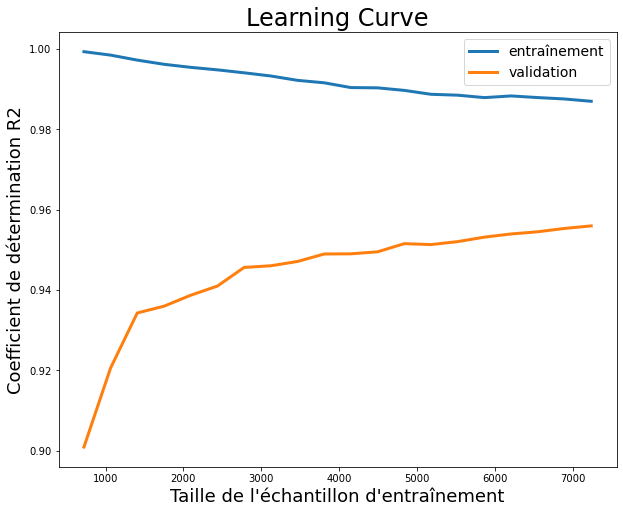

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(N,train_score.mean(axis=1),lw=3,label='entraînement')
plt.plot(N,np.nanmean(val_score,axis=1),lw=3,label='validation')
plt.title('Learning Curve',fontsize=24)
plt.xlabel('Taille de l\'échantillon d\'entraînement',fontsize=18)
plt.ylabel('Coefficient de détermination R2',fontsize=18)
plt.legend(fontsize=14)

In [44]:
model_registered.fit(X_train_registered,y_train_registered)
pred_registered = model_registered.predict(X_test)
model_registered.score(X_test,y_test_registered)

0.8758280786191748

In [47]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model_registered, X_train_registered, y_train_registered,
                           n_repeats=30)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] > 5e-3:
        print(f"{X_train_registered.columns[i]:<8} : "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

hours    : 1.421 +/- 0.016
workingday : 0.277 +/- 0.008
years    : 0.204 +/- 0.004
temp     : 0.043 +/- 0.001
season_4 : 0.038 +/- 0.001
humidity : 0.038 +/- 0.001
atemp    : 0.036 +/- 0.001
weather_3 : 0.019 +/- 0.001
week_days_7 : 0.008 +/- 0.000
months_4 : 0.007 +/- 0.000
windspeed : 0.007 +/- 0.000
week_days_5 : 0.007 +/- 0.000


In [106]:
import pickle
  
with open('../../app/model_registered.pkl', 'wb') as file:
    pickle.dump(model_registered, file)

## Modélisation casual

In [25]:
df_train_modify = pd.read_csv('../../csv/train_modifie.csv')
df_test_modify = pd.read_csv('../../csv/test_modifie.csv')

df_train = df_train_modify.drop(['day_length', 'day_light'], axis=1)
df_test = df_test_modify.drop(['day_length', 'day_light'], axis=1)

In [26]:
X_train = df_train.drop(['registered', 'casual'], axis=1)
y_train_casual = df_train['casual']

X_test = df_test.drop(['registered', 'casual'], axis=1)
y_test_casual = df_test['casual']

In [27]:
X_train_casual, _, y_train_casual, _ = train_test_split(X_train, y_train_casual, test_size=0.00001)

In [28]:
# On encode indépendamment de la normalisation car les données récupérées de l'API ne contiennent pas
# toutes les modalités de chaque variable catégorielle. Il en résulte que si l'on donne à prédire ce jeu
# de données à un modèle dont la pipeline contient un onehotencoder, il sortira dans le cas des données
# de l'API une cardinalité moindre pour les variables catégorielles que la cardinalité obtenue à l'entraînement.
# Une exception sera alors lancé par Python et le programme plantera...

encoded_features = ['season', 'weather', 'week_days', 'months']
ohe = make_column_transformer((OneHotEncoder(sparse=False),encoded_features), remainder='passthrough')
ohe.fit(X_train_casual)
X_train_ohe = ohe.transform(X_train_casual)
X_train_casual = pd.DataFrame(X_train_ohe)

X_test_ohe = ohe.transform(X_test)
X_test = pd.DataFrame(X_test_ohe)

In [29]:
features_name = {}
for i in range(X_train_casual.shape[1]):
    features_name[i] = ohe.get_feature_names_out()[i].replace("onehotencoder__","").replace("remainder__","")
X_train_casual = X_train_casual.rename(columns=features_name)
X_test = X_test.rename(columns=features_name)

In [30]:
#Features et pipelines
scaled_features = ['temp', 'atemp', 'windspeed', 'humidity', 'hours', 'years']#, 'day_length'
scaled_pipeline = make_pipeline(StandardScaler())

n_estimators = 140
max_depth = 7
subsample = 0.9
learning_rate = 0.1
colsample_bytree = 0.9
colsample_bylevel = 0.8
colsample_bynode = 0.9
gamma = 0.1

preprocessor = make_column_transformer((scaled_pipeline, scaled_features), remainder="passthrough")
xgb = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate,
          colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, colsample_bynode=colsample_bynode,
          gamma=gamma)
model_casual = make_pipeline(preprocessor, xgb)

{'xgbregressor__colsample_bylevel': 0.8,
 'xgbregressor__colsample_bynode': 0.9,
 'xgbregressor__colsample_bytree': 0.9,
 'xgbregressor__gamma': 0.1,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 140,
 'xgbregressor__subsample': 0.9}

In [ ]:
parameters = {'xgbregressor__n_estimators': np.arange(135,146,5),
              'xgbregressor__max_depth': np.arange(7,9,1),
              'xgbregressor__learning_rate':[0.1],
              'xgbregressor__subsample': [0.8,0.9,1],
              'xgbregressor__colsample_bytree': [0.8,0.9,1],
              'xgbregressor__colsample_bylevel': [0.8,0.9,1],
              'xgbregressor__colsample_bynode': [0.8,0.9,1],
              'xgbregressor__gamma': [0,0.1,0.2]}

grid = GridSearchCV(model_casual, parameters,cv=5)
grid.fit(X_train_casual, y_train_casual)

In [ ]:
grid.best_params_

In [31]:
# with mlflow.start_run(experiment_id = 1):

metrics = ['r2','neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','neg_median_absolute_error']
scores = cross_validate(model_casual,X_train_casual,y_train_casual,cv=5,scoring=metrics)

print(scores['test_r2'])
r2 = scores['test_r2'].mean()
print('r2 : ' + str(r2))
print('r2 adj. : ' + str(adjustedR2(r2,X_train_casual.shape[0],X_train_casual.shape[1])))
print('MSE : ' + str((-scores['test_neg_mean_squared_error']).mean()))
print('RMSE : ' + str((-scores['test_neg_root_mean_squared_error']).mean()))
print('MAE : ' + str((-scores['test_neg_mean_absolute_error']).mean()))
print('MdAE : ' + str((-scores['test_neg_median_absolute_error']).mean()))

    # """ Valeurs par défaut : 
    #     - n_estimators = 1
    #     - max_depth = 6
    #     - learning_rate = 0.3
    #     - gamma = 0
    #     - subsample = 1
    #     - colsample_bytree,  colsample_bylevel, colsample_bynode = 1
    # """
    # mlflow.log_param("casual n_estimators", n_estimators)
    # mlflow.log_param("casual max_depth", max_depth)
    # mlflow.log_param("casual learning_rate", learning_rate)
    # mlflow.log_param("casual gamma", gamma)
    # mlflow.log_param("casual subsample", subsample)
    # mlflow.log_param("casual colsample_bylevel", colsample_bylevel)
    # mlflow.log_param("casual colsample_bynode", colsample_bynode)
    # mlflow.log_param("casual colsample_bytree", colsample_bytree)

    # mlflow.log_metric("casual r2", r2)
    # mlflow.log_metric("casual r2 adj.", r2_adj)
    # mlflow.log_metric("casual MSE", mse)
    # mlflow.log_metric("casual RMSE", rmse)
    # mlflow.log_metric("casual MAE", mae) 
    # mlflow.log_metric("casual MdAE", mdae) 

[0.932364   0.92140392 0.93842983 0.93242739 0.92489385]
r2 : 0.9299038002135649
r2 adj. : 0.9296390805875804
MSE : 166.8966721798283
RMSE : 12.909876745021796
MAE : 7.738048939970507
MdAE : 4.042283630371093


In [ ]:
N, train_score, val_score = learning_curve(model_casual, X_train_casual, y_train_casual, train_sizes=np.linspace(0.1,1,20))

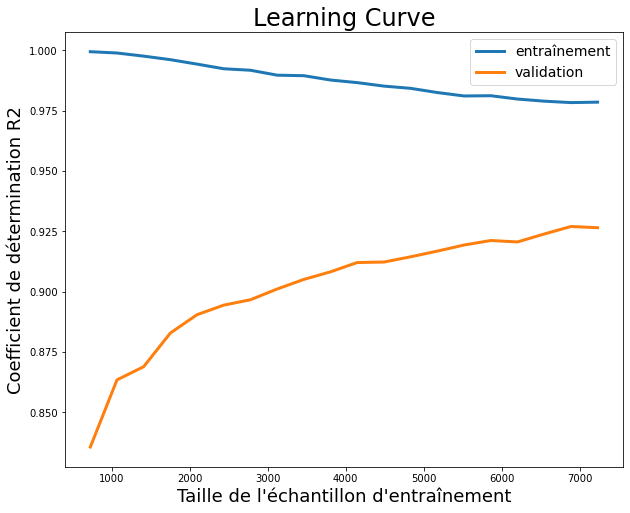

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(N,train_score.mean(axis=1),lw=3,label='entraînement')
plt.plot(N,np.nanmean(val_score,axis=1),lw=3,label='validation')
plt.title('Learning Curve',fontsize=24)
plt.xlabel('Taille de l\'échantillon d\'entraînement',fontsize=18)
plt.ylabel('Coefficient de détermination R2',fontsize=18)
plt.legend(fontsize=14)

In [32]:
model_casual.fit(X_train_casual,y_train_casual)
pred_casual = model_casual.predict(X_test)
model_casual.score(X_test,y_test_casual)

0.8737147725058916

In [46]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model_casual, X_train_casual, y_train_casual,
                           n_repeats=30)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] > 5e-3:
        print(f"{X_train_casual.columns[i]:<8} : "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

hours    : 0.866 +/- 0.015
workingday : 0.338 +/- 0.009
atemp    : 0.136 +/- 0.004
temp     : 0.134 +/- 0.004
years    : 0.086 +/- 0.004
humidity : 0.070 +/- 0.002
week_days_6 : 0.054 +/- 0.002
week_days_7 : 0.021 +/- 0.001
windspeed : 0.013 +/- 0.000
week_days_5 : 0.012 +/- 0.001
months_4 : 0.011 +/- 0.001
season_1 : 0.010 +/- 0.001
months_1 : 0.007 +/- 0.001
season_4 : 0.007 +/- 0.000
weather_1 : 0.006 +/- 0.000


In [120]:
import pickle
  
with open('../../app/model_casual.pkl', 'wb') as file:
    pickle.dump(model_casual, file)